<a href="https://colab.research.google.com/github/Fxf28/project-capstone/blob/main/capstone_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Library

In [ ]:
import os
from pathlib import Path
from typing import List, Tuple
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from PIL import Image, UnidentifiedImageError

## Load Dataset

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"faizfajar28","key":"f7fd442caa4184f869b5a7fd161e6ddc"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download joebeachcapital/realwaste
!unzip realwaste.zip

Dataset URL: https://www.kaggle.com/datasets/joebeachcapital/realwaste
License(s): Attribution 4.0 International (CC BY 4.0)
Archive:  realwaste.zip
  inflating: realwaste-main/README.md  
  inflating: realwaste-main/RealWaste/Cardboard/Cardboard_1.jpg  
  inflating: realwaste-main/RealWaste/Cardboard/Cardboard_10.jpg  
  inflating: realwaste-main/RealWaste/Cardboard/Cardboard_100.jpg  
  inflating: realwaste-main/RealWaste/Cardboard/Cardboard_101.jpg  
  inflating: realwaste-main/RealWaste/Cardboard/Cardboard_102.jpg  
  inflating: realwaste-main/RealWaste/Cardboard/Cardboard_103.jpg  
  inflating: realwaste-main/RealWaste/Cardboard/Cardboard_104.jpg  
  inflating: realwaste-main/RealWaste/Cardboard/Cardboard_105.jpg  
  inflating: realwaste-main/RealWaste/Cardboard/Cardboard_106.jpg  
  inflating: realwaste-main/RealWaste/Cardboard/Cardboard_107.jpg  
  inflating: realwaste-main/RealWaste/Cardboard/Cardboard_108.jpg  
  inflating: realwaste-main/RealWaste/Cardboard/Cardboard_109.jpg 

## Data Preparation

### List jumlah label dan gambar

In [ ]:
def list_image_folders(
    dataset_path: str = "path_datasetmu/",
    check_images: bool = True,
    min_images: int = 1
) -> List[Tuple[str, int]]:
    """
    Mencetak daftar folder dalam direktori dataset dengan informasi lengkap

    Parameters:
    - dataset_path: Path ke direktori dataset
    - check_images: Cek keberadaan file gambar dalam folder
    - min_images: Minimal jumlah gambar untuk ditampilkan

    Returns:
    - List of tuples (folder_name, image_count)
    """
    path = Path(dataset_path)

    # Validasi path secara detail
    if not path.exists():
        raise FileNotFoundError(f"Error: Direktori '{dataset_path}' tidak ditemukan")
    if not path.is_dir():
        raise NotADirectoryError(f"Error: '{dataset_path}' bukan direktori")

    # Dapatkan daftar folder dengan Path
    folders = []
    valid_extensions = {'.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff'}

    for entry in path.iterdir():
        if entry.is_dir():
            if check_images:
                # Hitung file gambar dalam folder
                image_count = sum(
                    1 for f in entry.iterdir()
                    if f.is_file() and f.suffix.lower() in valid_extensions
                )
            else:
                image_count = -1  # Flag untuk pengecekan disabled

            if image_count >= min_images:
                folders.append((entry.name, image_count))

    # Urutkan berdasarkan nama folder
    folders.sort(key=lambda x: x[0].lower())

    # Tampilkan output formatting
    if not folders:
        print("Tidak ada folder dengan gambar yang ditemukan")
        return []

    print(f"Ditemukan {len(folders)} folder di '{path.absolute()}':")
    max_name_length = max(len(f[0]) for f in folders)
    count_total = 0
    for i, (folder, count) in enumerate(folders, start=1):
        count_info = f"({count} gambar)" if check_images else ""
        print(f"{i:2d}. {folder:{max_name_length}} {count_info}")
        count_total += count

    print(f"Jumlah Gambar {count_total}")
    return folders

In [ ]:
if __name__ == "__main__":
    # Contoh penggunaan dengan berbagai opsi
    folders_info = list_image_folders(
        dataset_path="realwaste-main/RealWaste",
        check_images=True,
        min_images=5
    )

    # Untuk mendapatkan daftar folder saja
    folder_names = [f[0] for f in folders_info]
    print("\nDaftar folder tersedia:", folder_names)

Ditemukan 9 folder di '/content/realwaste-main/RealWaste':
 1. Cardboard           (461 gambar)
 2. Food Organics       (411 gambar)
 3. Glass               (420 gambar)
 4. Metal               (790 gambar)
 5. Miscellaneous Trash (495 gambar)
 6. Paper               (500 gambar)
 7. Plastic             (921 gambar)
 8. Textile Trash       (318 gambar)
 9. Vegetation          (436 gambar)
Jumlah Gambar 4752

Daftar folder tersedia: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']


### Cek Resolusi

In [32]:
def get_resolution_summary(dataset_path: str = "path_datasetmu/"):
    """
    Menganalisis resolusi gambar dalam semua sub-direktori (kelas)
    dan menghasilkan ringkasan resolusi untuk seluruh dataset.

    Args:
        base_dir (str): Path ke direktori utama dataset.

    Returns:
        None: Mencetak ringkasan resolusi untuk seluruh dataset.
    """
    resolutions = {}
    total_images = 0
    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            for filename in os.listdir(class_path):
                filepath = os.path.join(class_path, filename)
                try:
                    with Image.open(filepath) as img:
                        width, height = img.size
                        resolution = (width, height)
                        resolutions[resolution] = resolutions.get(resolution, 0) + 1
                        total_images += 1
                except Exception as e:
                    print(f"Gagal membuka atau membaca gambar: {filepath} - {e}")

    unique_resolutions = set(resolutions.keys())
    print(f"Resolusi yang ditemukan: {unique_resolutions}")

    if len(unique_resolutions) == 1:
        for res in unique_resolutions:
            print(f"Semua gambar memiliki resolusi yang seragam: {res}")
    else:
        print("Resolusi tidak seragam.")

    print("\nJumlah gambar per resolusi:")
    for resolution, count in sorted(resolutions.items()):
        print(f"Resolusi {resolution}: {count} gambar")

In [33]:
get_resolution_summary(dataset_path="realwaste-main/RealWaste")

Resolusi yang ditemukan: {(524, 524)}
Semua gambar memiliki resolusi yang seragam: (524, 524)

Jumlah gambar per resolusi:
Resolusi (524, 524): 4752 gambar


### Plot Sample

In [ ]:
def plot_category_samples(
    dataset_path: str = "path_datasetmu/",
    samples_per_category: int = 5,
    figsize: tuple = (14, 6),
    label_fontsize: int = 12,
    dpi: int = 100
) -> plt.Figure:
    """
    Memvisualisasikan sampel gambar dari setiap kategori dalam dataset

    Parameters:
    - dataset_path: Path ke direktori dataset
    - samples_per_category: Jumlah sampel gambar per kategori yang akan ditampilkan
    - figsize: Ukuran figure matplotlib (width, height)
    - label_fontsize: Ukuran font label kategori
    - dpi: Kualitas output gambar

    Returns:
    - matplotlib Figure object
    """
    path = Path(dataset_path)

    # Validasi path
    if not path.exists():
        raise FileNotFoundError(f"Path '{dataset_path}' tidak ditemukan")
    if not path.is_dir():
        raise NotADirectoryError(f"'{dataset_path}' bukan direktori")

    # Cari kategori dengan gambar
    categories = []
    valid_extensions = {'.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff'}

    for category_dir in path.iterdir():
        if category_dir.is_dir():
            # Cek file gambar dengan glob
            image_files = list(category_dir.glob('*'))
            if any(f.suffix.lower() in valid_extensions for f in image_files):
                categories.append(category_dir.name)

    categories.sort()

    if not categories:
        print("Tidak ada kategori dengan gambar yang ditemukan")
        return None

    # Setup plot
    n_rows = len(categories)
    n_cols = samples_per_category
    fig, axs = plt.subplots(
        n_rows, n_cols,
        figsize=(figsize[0], figsize[1] + n_rows*0.5),  # Dynamic height
        dpi=dpi,
        gridspec_kw={'wspace':0.05, 'hspace':0.3}
    )

    # Handle single category case
    if n_rows == 1:
        axs = np.expand_dims(axs, axis=0)

    # Hitung margin kiri berdasarkan panjang nama kategori terpanjang
    max_name_length = max(len(cat) for cat in categories)
    plt.subplots_adjust(left=0.2 + 0.01*max_name_length)

    # Plot gambar untuk setiap kategori
    for row_idx, category in enumerate(categories):
        category_path = path / category
        image_files = [
            f for f in category_path.iterdir()
            if f.is_file() and f.suffix.lower() in valid_extensions
        ]

        # Pilih sampel acak dengan jaminan unique
        selected_images = []
        if len(image_files) > 0:
            n_samples = min(samples_per_category, len(image_files))
            selected_indices = np.random.choice(len(image_files), n_samples, replace=False)
            selected_images = [image_files[i] for i in selected_indices]

        # Inisialisasi subplots
        for col_idx in range(n_cols):
            ax = axs[row_idx, col_idx]
            ax.axis('off')
            ax.set_facecolor('#f0f0f0')  # Warna background netral

            # Jika ada gambar yang valid
            if col_idx < len(selected_images):
                try:
                    img = Image.open(selected_images[col_idx])
                    ax.imshow(img)

                    # Tambah border
                    for spine in ax.spines.values():
                        spine.set_visible(True)
                        spine.set_edgecolor('#808080')
                        spine.set_linewidth(0.5)

                except (UnidentifiedImageError, OSError) as e:
                    self._add_error_text(ax, f"Error: {e}")
            else:
                self._add_error_text(ax, "Tidak ada gambar")

        # Tambah label kategori
        axs[row_idx, 0].text(
            -0.3, 0.5,
            category,
            transform=axs[row_idx, 0].transAxes,
            fontsize=label_fontsize,
            fontweight='bold',
            va='center',
            ha='right',
            bbox=dict(
                boxstyle='round',
                facecolor='white',
                edgecolor='#404040',
                alpha=0.8,
                pad=0.3
            )
        )

    plt.show()
    return fig

def _add_error_text(ax, text: str):
    """Helper untuk menambahkan text error di subplot"""
    ax.text(
        0.5, 0.5,
        text,
        ha='center',
        va='center',
        color='red',
        fontsize=8,
        wrap=True
    )
    ax.set_facecolor('#fff0f0')  # Background merah muda untuk error

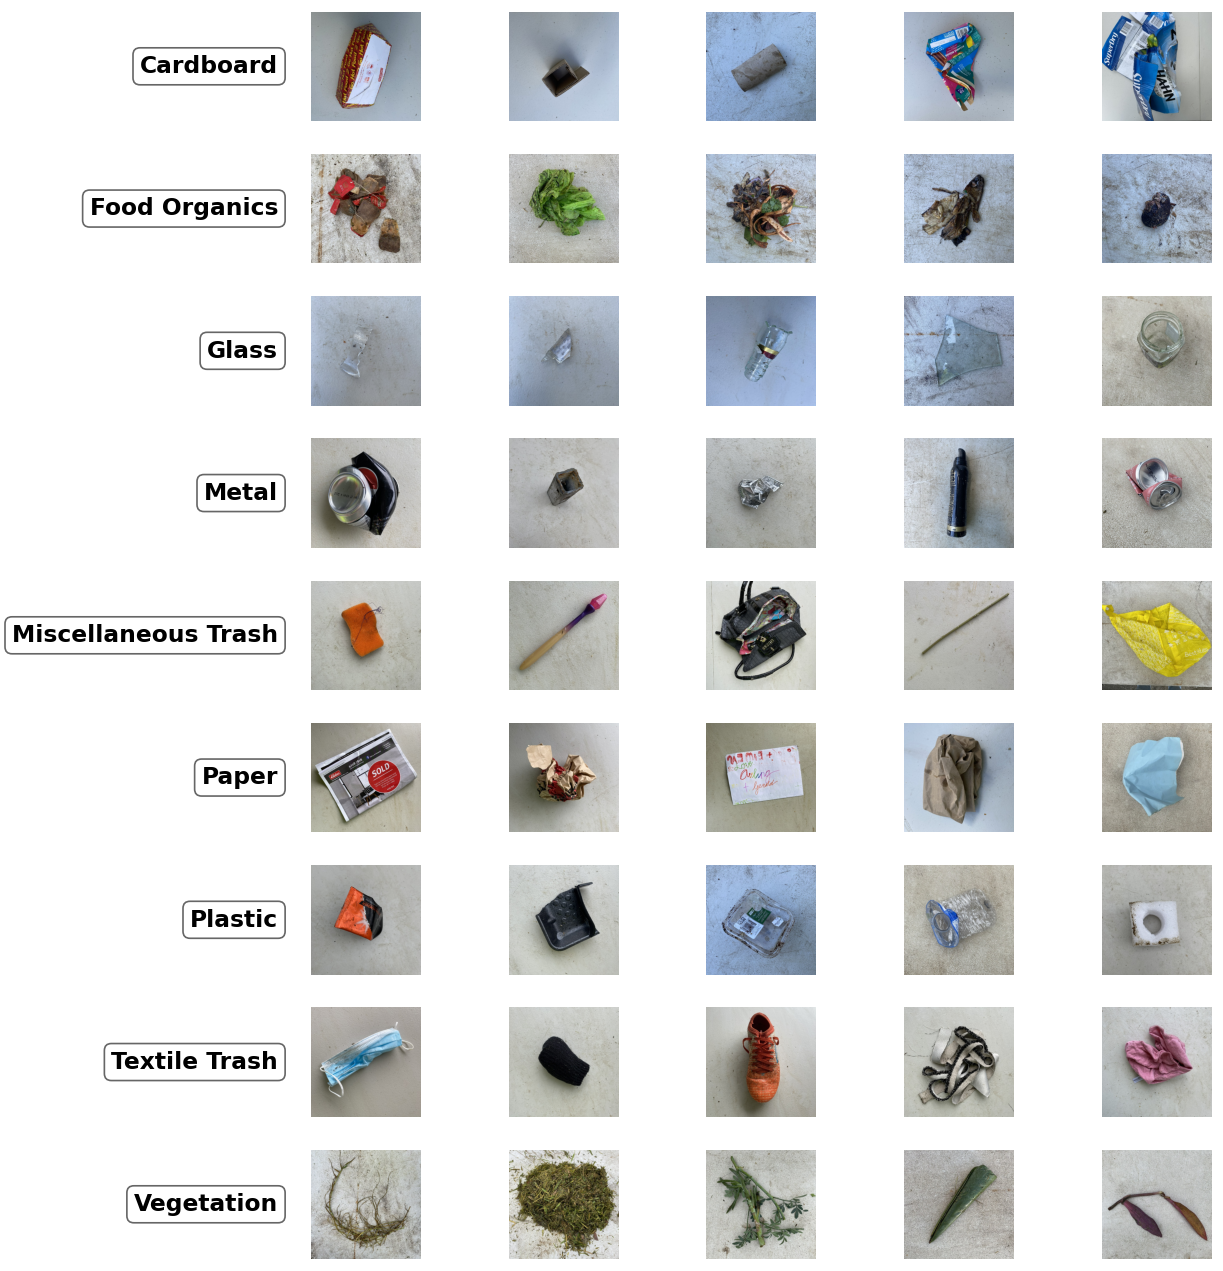

In [ ]:
if __name__ == "__main__":
    fig = plot_category_samples(
        dataset_path="realwaste-main/RealWaste",
        samples_per_category=5,
        figsize=(16, 9),
        label_fontsize=14,
        dpi=120
    )

### Distribusi Gambar per Kelas

In [ ]:
def analyze_dataset_distribution(dataset_path: str = "path_datasetmy/") -> pd.DataFrame:
    """
    Menganalisis distribusi dataset dan membuat visualisasi

    Parameters:
    - dataset_path: Path ke direktori dataset

    Returns:
    - DataFrame berisi metadata dataset
    """
    path = Path(dataset_path)
    valid_extensions = {'.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff'}

    # Validasi path
    if not path.exists():
        raise FileNotFoundError(f"Dataset path '{dataset_path}' tidak ditemukan")
    if not path.is_dir():
        raise NotADirectoryError(f"'{dataset_path}' bukan direktori")

    # Kumpulkan data dengan pathlib
    image_data = []
    for img_path in path.rglob('*'):
        if img_path.is_file() and img_path.suffix.lower() in valid_extensions:
            relative_path = img_path.relative_to(path)
            label = relative_path.parts[0]  # Ambil direktori level pertama
            image_data.append({
                "path": str(img_path),
                "file_name": img_path.name,
                "label": label,
                "extension": img_path.suffix.lower()
            })

    if not image_data:
        raise ValueError("Tidak ditemukan gambar valid dalam dataset")

    df = pd.DataFrame(image_data)

    # Plot distribusi
    plt.figure(figsize=(14, 8))
    ax = sns.countplot(
        data=df,
        y='label',
        hue='label',
        legend=False,
        order=df['label'].value_counts().index,
        palette='viridis'
    )

    # Tambah annotasi
    total_images = len(df)
    for p in ax.patches:
        width = p.get_width()
        ax.annotate(
            f'{int(width)}\n({width/total_images:.1%})',
            (width + 0.1, p.get_y() + p.get_height()/2),
            ha='left',
            va='center'
        )

    plt.title(
        f"Distribusi Dataset - Total {len(df)} Gambar ({len(df['label'].unique())} Kategori)",
        fontsize=14,
        pad=20
    )
    plt.xlabel("Jumlah Gambar", labelpad=15)
    plt.ylabel("Kategori", labelpad=15)
    plt.xlim(0, df['label'].value_counts().max() * 1.15)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    return df

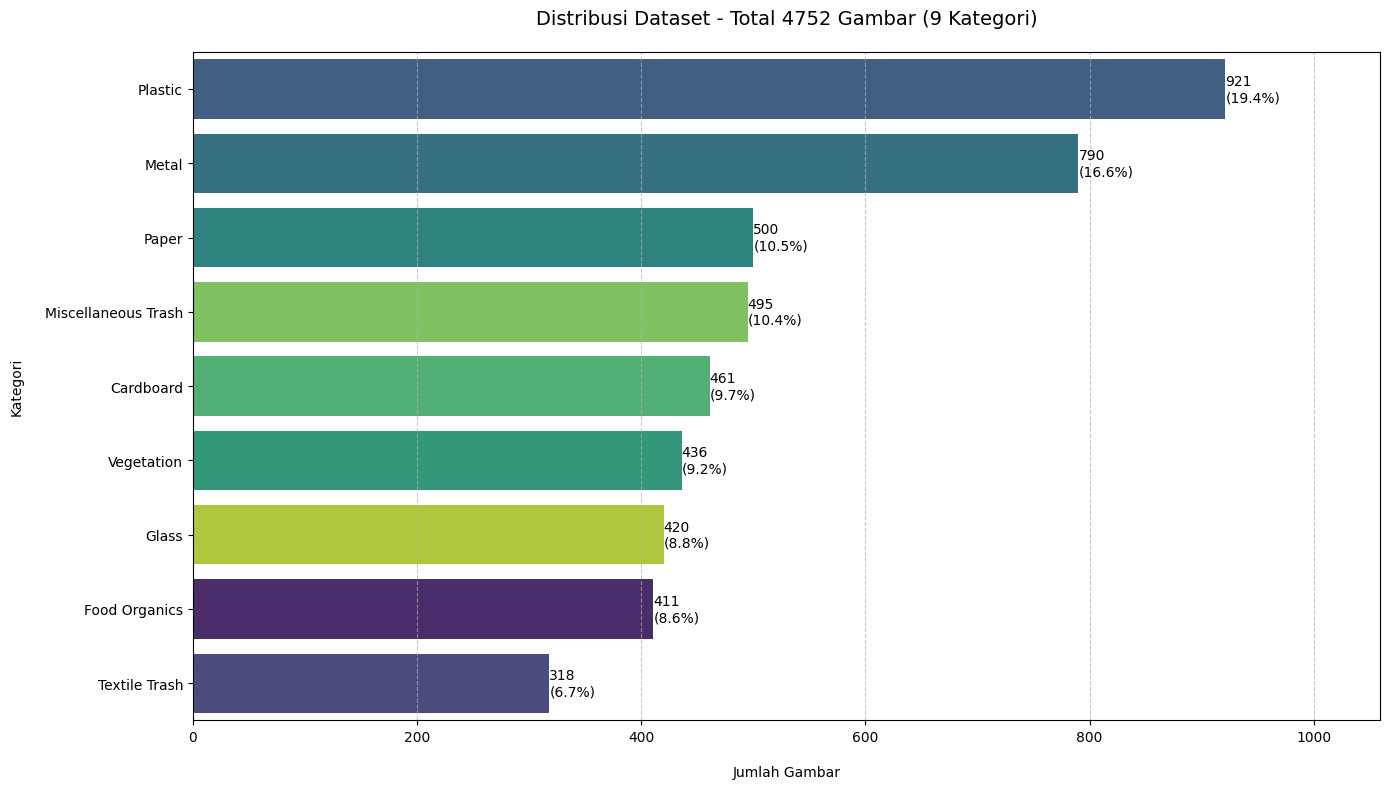


Contoh data:
                                                   path  \
686   realwaste-main/RealWaste/Textile Trash/Textile...   
4733         realwaste-main/RealWaste/Glass/Glass_8.jpg   
77    realwaste-main/RealWaste/Food Organics/Food Or...   
268   realwaste-main/RealWaste/Food Organics/Food Or...   
3603  realwaste-main/RealWaste/Cardboard/Cardboard_2...   

                  file_name          label extension  
686    Textile Trash_48.jpg  Textile Trash      .jpg  
4733            Glass_8.jpg          Glass      .jpg  
77    Food Organics_253.jpg  Food Organics      .jpg  
268   Food Organics_234.jpg  Food Organics      .jpg  
3603      Cardboard_251.jpg      Cardboard      .jpg  


In [34]:
if __name__ == "__main__":
    dataset_df = analyze_dataset_distribution(
        dataset_path="realwaste-main/RealWaste/"
    )
    print("\nContoh data:")
    print(dataset_df.sample(5))

## Data Augmentation

Target Augmentasi 1000 gambar per kelas(total 9000)

## Data Preparation

Data splitting train val test

## Pemodelan

1. ML Klasik
2. Computer Vision

### Evaluasi

## Konversi Model

## Inferensi